In [1]:
%pdb off

Automatic pdb calling has been turned OFF


In [2]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
import copy
from sklearn.model_selection import train_test_split


# for importing data
import torchvision

import matplotlib.pyplot as plt

from typing import Tuple, Sequence, List, Optional


In [3]:
import logging

# Configure logging
logging.basicConfig(
    level=logging.DEBUG,              # change to DEBUG for more details
    format="%(asctime)s [%(levelname)s] %(message)s",
    datefmt="%H:%M:%S"
)

In [4]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

# Import and inspect the data

In [5]:
# download the dataset
cdata = torchvision.datasets.EMNIST(root='emnist',split='letters',download=True)

# more info: https://www.nist.gov/itl/products-and-services/emnist-dataset

In [6]:
# inspect the data

# the categories (but how many letters??)
print(cdata.classes)
print(str(len(cdata.classes)) + ' classes')

print('\nData size:')
print(cdata.data.shape)

# transform to 4D tensor for conv layers (and transform from int8 to float)
images = cdata.data.unsqueeze(dim=1).float()
print('\nTensor data:')
print(images.shape)

print('\nTarget data:')
print(torch.unique(cdata.targets))

['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
27 classes

Data size:
torch.Size([124800, 28, 28])

Tensor data:
torch.Size([124800, 1, 28, 28])

Target data:
tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 23, 24, 25, 26])


In [7]:
# so therefore we'll eliminate it and subtract 1 from the original

# remove the first class category
letterCategories = cdata.classes[1:]

# relabel labels to start at 0
labels = copy.deepcopy(cdata.targets)-1
print(labels.shape)

###
print( torch.sum(labels==0) )
torch.unique(labels)

torch.Size([124800])
tensor(4800)


tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25])

In [8]:
# Normalizing images

images /= torch.max(images)

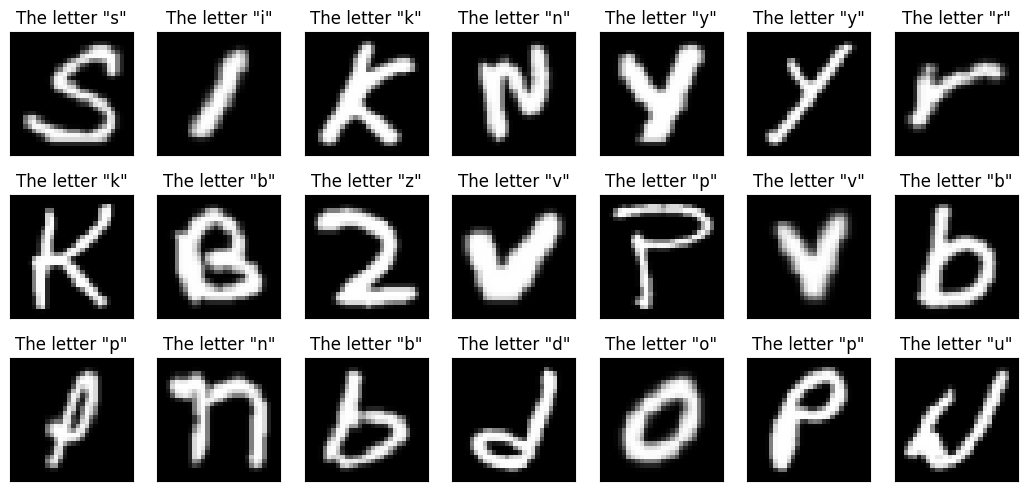

In [9]:
# visualize some images
fig,axs = plt.subplots(3,7,figsize=(13,6))

for i,ax in enumerate(axs.flatten()):

  # pick a random pic
  whichpic = np.random.randint(images.shape[0])

  # extract the image and its target letter
  I = np.squeeze( images[whichpic,:,:] )
  letter = letterCategories[labels[whichpic]]

  # visualize
  ax.imshow(I.T,cmap='gray')
  ax.set_title('The letter "%s"'%letter)
  ax.set_xticks([])
  ax.set_yticks([])

plt.show();

# Create train/test groups using DataLoader

In [10]:
import os
# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(images, labels, test_size=.1)

# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True, num_workers=max(2,os.cpu_count()//2),pin_memory=(device.type=='cuda'),persistent_workers=True,prefetch_factor=2)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [11]:
# check size (should be images X channels X width X height
print( train_loader.dataset.tensors[0].shape )
print( train_loader.dataset.tensors[1].shape )

torch.Size([112320, 1, 28, 28])
torch.Size([112320])


# Create the DL model

In [12]:
# Helper functions

def _pair(x):
    if isinstance(x, (list, tuple)):
        if len(x) == 1: return (x[0], x[0])
        if len(x) == 2: return (x[0], x[1])
        raise ValueError(f"_pair expects scalar or len-1/2, got {x}")
    return (x, x)

def conv2d_out_hw(HW, kernel_size, stride, padding, dilation):
    # Loud sanity checks so you see where the length-3 is coming from
    def _chk(name, v):
        if isinstance(v, (list, tuple)) and len(v) not in (1,2):
            raise ValueError(f"{name} must be scalar/len-1/2, but got {v} (len={len(v)})")
        return v

    H, W = HW
    kH, kW = _pair(kernel_size)
    sH, sW = _pair(stride)
    dH, dW = _pair(dilation)
    pH, pW = _pair(padding)

    # Layer[n]-In = floor((Iayer[n-1n]- out + 2*padding - dilation*(kernel-1)-1)/stride + 1)
    outH = np.floor((H + 2*pH - dH*(kH-1) - 1)/sH + 1)
    outW = np.floor((W + 2*pW - dW*(kW-1) - 1)/sW + 1)

    return int(outH), int(outW)

def _as_list(value, n: int):
    """Normalize a scalar/tuple/sequence into a list of length n.
       - If value is a scalar or tuple, replicate it n times.
       - If value is a sequence of length 1, replicate it n times.
       - If value is a sequence of length n, use as is.
    """

    # tuples are valid for kernel/stride/padding/dilation
    if isinstance(value, (int, float, tuple)):
        return [value for _ in range(n)]
    if isinstance(value, Sequence):
        if len(value) == 1 and n > 1:
            return [value[0] for _ in range(n)]
        if len(value) == n:
            return list(value)
    raise ValueError(f"Could not broadcast parameter to length {n}: {value}")



In [13]:
# create a class for the model

def makeTheNet(imgSize: Tuple[int, int],           #H,W
                in_channels: int = 1,
                out_channels: Sequence[int] = [6,6],         #conv1, conv2
                kernel_size: int | Tuple[int, int]=3,
                stride: int | Tuple[int, int]=1,
                # padding: Optional[int | Tuple[int, int]]=[(1,1),(0,0),(0,0)],
                padding: Optional[int | Tuple[int, int]]=[1,0,0],
                pool_size: Optional[Tuple[int, int]]=(2,2),
                dilation: int | Tuple[int, int]=1,
                groups: int =1,
                bias: bool =True,
                padding_mode: str='zeros',
                cv_dropout: float = 0.0,

                # Defintions for the FC layer
                uLinear: Optional[Sequence[int]] = [50],
                use_batchnorm: bool = True,
                out_size: int = 26,
                ln_dropout: float = 0.0,

                # Regularization
                optimizer = 'Adam',
                weight_decay: float = 0.0,
                lr: float = 1e-3,

                device=None,
                dtype=None,
                printtoggle: bool = False):

  class emnistnet(nn.Module):
    def __init__(self,
                imgSize: Tuple[int, int] = imgSize,           #H,W
                in_channels: int = in_channels,
                out_channels: Sequence[int] = out_channels,     #conv1, conv2
                kernel_size: int | Tuple[int, int]=kernel_size,
                stride: int | Tuple[int, int]=stride,
                padding: Optional[int | Tuple[int, int]]=padding,
                pool_size: Optional[Tuple[int, int]]=pool_size,
                dilation: int | Tuple[int, int]=dilation,
                groups: int =groups,
                bias: bool = bias,
                padding_mode: str=padding_mode,
                cv_dropout: float = cv_dropout,

                # Defintions for the FC layer
                uLinear: Optional[Sequence[int]] = uLinear,
                use_batchnorm: bool = use_batchnorm,
                out_size: int = out_size,
                ln_dropout: float = ln_dropout,
                device=device,
                dtype=dtype,
                printtoggle: bool = printtoggle
                ):
      super().__init__()

      # right at the start of __init__ or before building convs
      assert isinstance(in_channels, int) and in_channels > 0, f"in_channels must be > 0, got {in_channels}"
      for i, oc in enumerate(out_channels):
          assert int(oc) > 0, f"out_channels[{i}] must be > 0, got {oc}"


      # print toggle
      self.printtoggle = printtoggle

      self.pool = nn.MaxPool2d(pool_size)

      self.use_batchnorm = use_batchnorm

      nBlocks = len(out_channels)               # number of conv blocks

      # Normalize per-block parameters
      k_list = _as_list(kernel_size, nBlocks)
      s_list = _as_list(stride,      nBlocks)
      p_list = _as_list(padding,     nBlocks)
      d_list = _as_list(dilation,    nBlocks)
      pool_list = _as_list(pool_size, nBlocks)

      #--------Build Convoluation Blocks----------
      convs = []
      cbns = []                 # Batch normalization for each layer
      pools = []
      cdo = []                 # Dropout per convolution block (optional)


      prev_c = in_channels

      # ---- Convolutional stack ----
      for i in range(nBlocks):
        convs.append(nn.Conv2d(
        in_channels=prev_c,
        out_channels=out_channels[i],
        kernel_size=k_list[i],
        stride=s_list[i],
        padding=p_list[i],
        dilation=d_list[i],
        groups=groups,
        bias=bias,
        padding_mode=padding_mode
    ))

        if self.use_batchnorm:
          cbns.append(nn.BatchNorm2d(out_channels[i]))
        else:
          cbns.append(nn.Identity())

        pools.append(nn.MaxPool2d(kernel_size=pool_list[i]))

        if cv_dropout > 0:
          cdo.append(nn.Dropout2d(cv_dropout))
        else:
          cdo.append(nn.Identity())

        prev_c = out_channels[i]

      self.convs = nn.ModuleList(convs)
      self.cbns  = nn.ModuleList(cbns)
      self.pools = nn.ModuleList(pools)
      self.cdo   = nn.ModuleList(cdo)

      # Safety checks (helps catch the “zip returns nothing” bug)
      assert len(self.convs) > 0, "No conv blocks built"
      assert len(self.convs) == len(self.pools) == len(self.cbns) == len(self.cdo), (len(self.convs), len(self.pools), len(self.cbns), len(self.cdo))


      #---- Compute flattened features using formula
      H, W = imgSize
      c_out = out_channels[-1]
      for i in range(nBlocks):

          H, W = conv2d_out_hw((H,W),
                               kernel_size=self.convs[i].kernel_size,
                               stride=self.convs[i].stride,
                               padding=self.convs[i].padding,
                               dilation=self.convs[i].dilation
                              )

          poolH, poolW = _pair(pool_list[i])
          H//= poolH
          W//= poolW

          if self.printtoggle:
            print(f'Block {i+1}: after conv -> ({H*poolH},{W*poolW}); after pool {poolH}x{poolW} -> ({H},{W})')

      flat = int(c_out * max(H,0) * max(W,0))
      if flat <= 0:
                raise ValueError(f"Computed non-positive flattened features: {flat}. "
                                 f"Check conv/pool parameters vs input size {imgSize}.")


      # --- Linear stack/ Multi-Layer Perceptorn (MLP) (variable depth) ---
      sizes = list(uLinear) if uLinear is not None else [50]
      fcs, fbns, fdo = [], [], []

      in_f = flat

      for h in sizes:
          fcs.append(nn.Linear(in_f, h))
          if self.use_batchnorm:
            fbns.append(nn.BatchNorm1d(h))
          else:
            fbns.append(nn.Identity())
          if ln_dropout > 0:
              fdo.append(nn.Dropout(ln_dropout))
          else:
              fdo.append(nn.Identity())

          in_f = h


      self.fcs  = nn.ModuleList(fcs)
      self.fbns = nn.ModuleList(fbns)
      self.fdo  = nn.ModuleList(fdo)
      self.output_layer = nn.Linear(in_f, out_size)

    def forward(self,x):

      if self.printtoggle: print(f'Input: {list(x.shape)}')

      # Convolutional stack: Conv -> (BN) -> Max_Pool -> LeakyReLU -> (Dropout2d)
      for i in range(len(self.convs)):

        x = self.convs[i](x)
        x = self.cbns[i](x)
        x = self.pools[i](x)
        x = F.leaky_relu(x, inplace=True)
        x = self.cdo[i](x)

        if self.printtoggle: print(f'After block {i+1}: {list(x.shape)}')
        if self.printtoggle: print(f'Block {i+1} padding {self.convs[i].padding}')

      # reshape for linear layer
      x = torch.flatten(x,start_dim=1)
      if self.printtoggle: print(f'Vectorized: {list(x.shape)}')

      ## FC stack
      for i in range(len(self.fcs)):

        x = self.fcs[i](x)
        x = self.fbns[i](x)
        x = F.leaky_relu(x, inplace=True)
        x = self.fdo[i](x)

        if self.printtoggle: print(f'After FC {i+1}: {list(x.shape)}')


      x = self.output_layer(x)

      return x

  #-------------------End of model factory------------------------------

  # create the model instance
  net = emnistnet()

  # Move to device/dtype once (constructor kwargs are version-fragile)
  if device is not None or dtype is not None:
      net = net.to(device=device, dtype=dtype)

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = getattr(torch.optim,optimizer)(net.parameters(),lr=lr,weight_decay=weight_decay)

  return net,lossfun,optimizer

In [14]:
# test the model with one batch
net,lossfun,optimizer = makeTheNet((images.shape[2],images.shape[3]),printtoggle=True, out_channels=[64,128,256],uLinear=[256,64])

X,y = next(iter(train_loader))
yHat = net(X)

# check size of output
print('\nOutput size:')
print(yHat.shape)

# # now let's compute the loss
loss = lossfun(yHat,torch.squeeze(y))
print(' ')
print('Loss:')
print(loss)

Block 1: after conv -> (28,28); after pool 2x2 -> (14,14)
Block 2: after conv -> (12,12); after pool 2x2 -> (6,6)
Block 3: after conv -> (4,4); after pool 2x2 -> (2,2)
Input: [32, 1, 28, 28]
After block 1: [32, 64, 14, 14]
Block 1 padding (1, 1)
After block 2: [32, 128, 6, 6]
Block 2 padding (0, 0)
After block 3: [32, 256, 2, 2]
Block 3 padding (0, 0)
Vectorized: [32, 1024]
After FC 1: [32, 256]
After FC 2: [32, 64]

Output size:
torch.Size([32, 26])
 
Loss:
tensor(3.3401, grad_fn=<NllLossBackward0>)


# Create a function that trains the model

In [15]:
from tqdm import tqdm

def function2trainTheModel(
    numepochs: int,
    imgSize: tuple[int, int] | None = None,
    in_channels: int | None = None,
    out_channels: list[int] = [6, 6],
    kernel_size: int | tuple[int, int] = 3,
    stride: int | tuple[int, int] = 1,
    padding: int | tuple[int, int] | list[tuple[int, int]] = [1, 0, 0],
    pool_size: tuple[int, int] = (2, 2),
    dilation: int | tuple[int, int] = 1,
    groups: int = 1,
    bias: bool = True,
    padding_mode: str = "zeros",
    cv_dropout: float = 0.0,
    uLinear: list[int] = [50],
    use_batchnorm: bool = False,
    out_size: int = 26,
    ln_dropout: float = 0.0,
    optimizer: str = "Adam",          # name of optimizer (Adam, AdamW, SGD, ...)
    weight_decay: float = 0.0,
    lr: float = 1e-3,
    device: torch.device | None = None,
    dtype=None,
    printtoggle: bool = False,
):
    # ---------- Device selection (don’t rely on outer globals) ----------
    if device is None:
        if torch.cuda.is_available():
            device = torch.device("cuda")
        elif torch.backends.mps.is_available():
            device = torch.device("mps")
        else:
            device = torch.device("cpu")
    print("Using device:", device)

    # ---------- Infer shape once (avoid defaults that read global `images`) ----------
    if imgSize is None or in_channels is None:
        bx, by = next(iter(train_loader))
        imgSize = (bx.shape[2], bx.shape[3]) if imgSize is None else imgSize
        in_channels = int(bx.shape[1]) if in_channels is None else in_channels

    # ---------- Build model/criterion/optimizer ----------
    # Avoid name shadowing: keep the optimizer NAME separate from the instance
    opt_name = optimizer
    net, lossfun, opt = makeTheNet(
        imgSize,
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=kernel_size,
        stride=stride,
        padding=padding,
        pool_size=pool_size,
        dilation=dilation,
        groups=groups,
        bias=bias,
        padding_mode=padding_mode,
        cv_dropout=cv_dropout,
        uLinear=uLinear,
        use_batchnorm=use_batchnorm,
        out_size=out_size,
        ln_dropout=ln_dropout,
        optimizer=opt_name,
        weight_decay=weight_decay,
        lr=lr,
        device=device,   # safely pass device through
        dtype=dtype,
        printtoggle=printtoggle,
    )

    net.to(device)
    lossfun = lossfun.to(device)

    # ---------- AMP (new API); enable only on CUDA ----------
    use_cuda = (device.type == "cuda")
    scaler = torch.amp.GradScaler(enabled=use_cuda)
    autocast_ctx = torch.autocast(device_type="cuda",dtype=torch.float16, enabled=use_cuda)

    # ---------- Metrics (avoid per-batch .item() → sync once/epoch) ----------
    trainLoss = torch.zeros(numepochs)
    testLoss  = torch.zeros(numepochs)
    trainErr  = torch.zeros(numepochs)
    testErr   = torch.zeros(numepochs)

    # ---------- Epoch loop ----------
    for epochi in tqdm(range(numepochs), desc="Epoch"):
        net.train()
        batch_loss_sum = torch.zeros((), device=device)
        err_count = torch.zeros((), device=device, dtype=torch.long)
        n_seen = 0

        for X, y in tqdm(train_loader, desc="Batch", leave=False):
            X = X.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)

            opt.zero_grad(set_to_none=True)

            with autocast_ctx:
                yHat = net(X)
                loss = lossfun(yHat, y)

            if use_cuda:
                scaler.scale(loss).backward()
                scaler.step(opt)
                scaler.update()
            else:
                loss.backward()
                opt.step()

            # accumulate on device (no CPU sync)
            with torch.no_grad():
                batch_loss_sum += loss.detach() * y.size(0)
                err_count += (yHat.argmax(dim=1) != y).sum()
                n_seen += y.size(0)

        # end train epoch: sync once
        trainLoss[epochi] = (batch_loss_sum / max(n_seen, 1)).detach().cpu()
        trainErr[epochi]  = (100.0 * err_count.float() / max(n_seen, 1)).detach().cpu()

        # ---------- Evaluation on full test loader (not a single batch) ----------
        net.eval()
        test_loss_sum = torch.zeros((), device=device)
        test_err_count = torch.zeros((), device=device, dtype=torch.long)
        test_seen = 0

        with torch.no_grad():
            for X, y in test_loader:
                X = X.to(device, non_blocking=True)
                y = y.to(device, non_blocking=True)
                yHat = net(X)
                test_loss_sum += lossfun(yHat, y) * y.size(0)
                test_err_count += (yHat.argmax(dim=1) != y).sum()
                test_seen += y.size(0)

        testLoss[epochi] = (test_loss_sum / max(test_seen, 1)).detach().cpu()
        testErr[epochi]  = (100.0 * test_err_count.float() / max(test_seen, 1)).detach().cpu()

    # done
    return trainLoss, testLoss, trainErr, testErr, net


# Run the model and show the results!

In [16]:
trainLoss,testLoss,trainErr,testErr,net = function2trainTheModel(10, out_channels=[64,128,256],uLinear=[256,64], printtoggle=False)

Using device: cuda


Epoch: 100%|██████████| 10/10 [03:47<00:00, 22.71s/it]


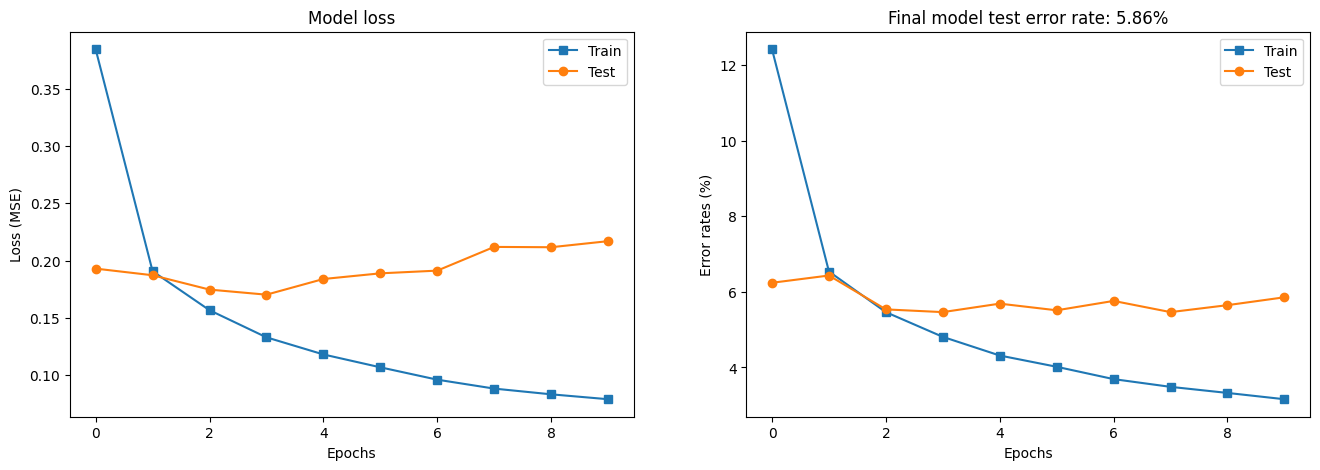

In [17]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(testLoss,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')
ax[0].legend()

ax[1].plot(trainErr,'s-',label='Train')
ax[1].plot(testErr,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Error rates (%)')
ax[1].set_title(f'Final model test error rate: {testErr[-1]:.2f}%')
ax[1].legend()

plt.show();

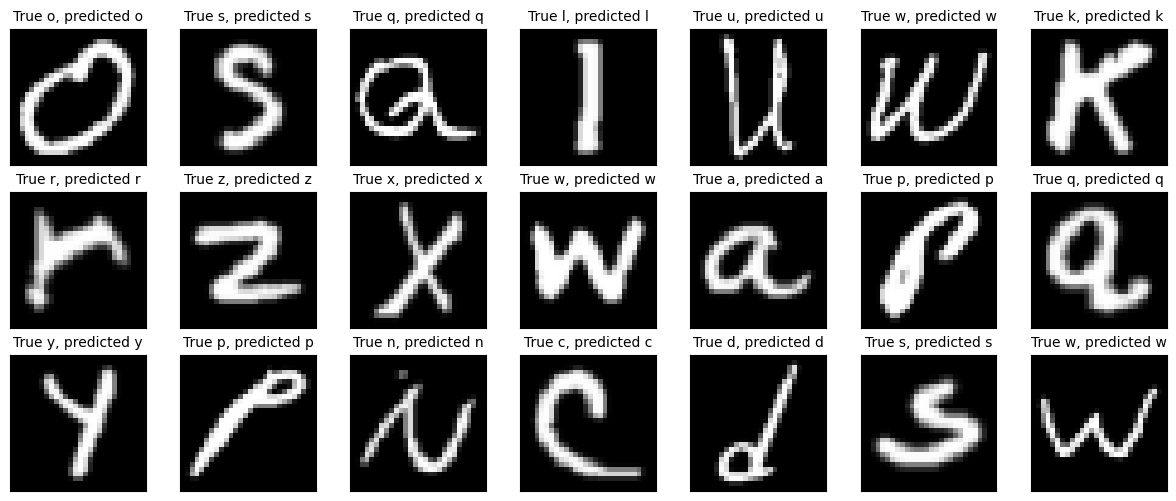

In [18]:
### visualize some images

# extract X,y from test dataloader
X,y = next(iter(test_loader))
X = X.to(device) # push data to GPU
y = y.to(device) # push data to GPU

# Ensure the model is on the correct device
net = net.to(device)

yHat = net(X)

# pick some examples at random to show
randex = np.random.choice(len(y),size=21,replace=False)

# visualize some images
fig,axs = plt.subplots(3,7,figsize=(15,6))

for i,ax in enumerate(axs.flatten()):

  # extract the image and its target letter
  I = np.squeeze( X[randex[i],0,:,:] ).cpu() # .cpu() to transfer back from GPU!
  trueLetter = letterCategories[ y[randex[i]] ]
  predLetter = letterCategories[ torch.argmax(yHat[randex[i],:]) ]

  # color-code the accuracy (using ternary operator)
  col = 'gray' if trueLetter==predLetter else 'hot'

  # visualize
  ax.imshow(I.T,cmap=col)
  ax.set_title('True %s, predicted %s' %(trueLetter,predLetter),fontsize=10)
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

# Accuracy by letter

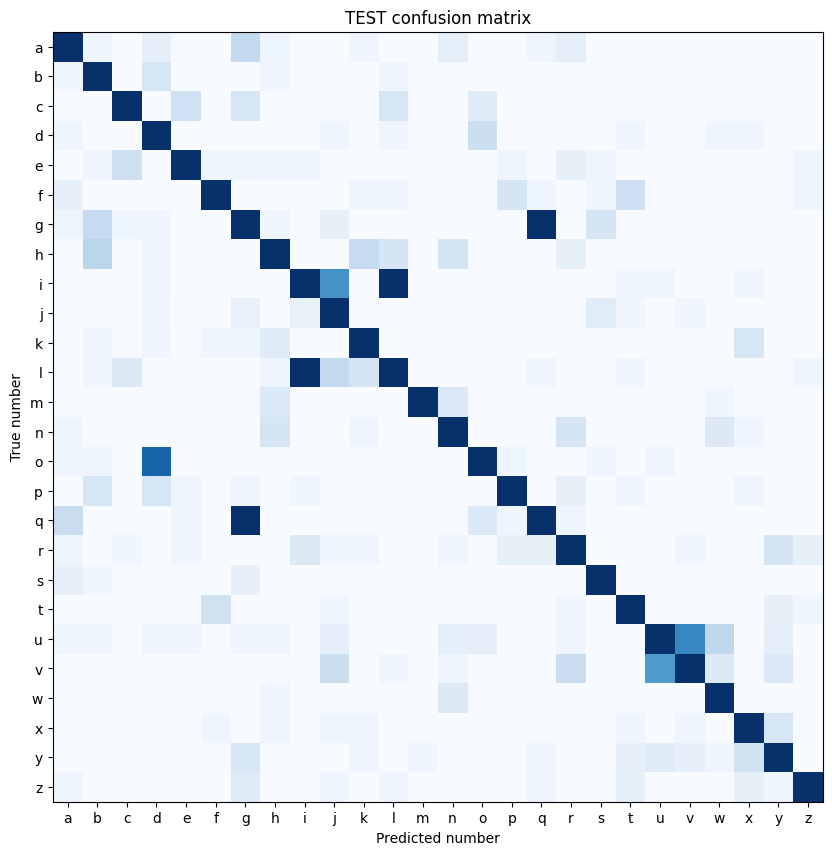

In [19]:
import sklearn.metrics as skm

# compute the confusion matrix
C = skm.confusion_matrix(y.cpu(),torch.argmax(yHat.cpu(),axis=1),normalize='true')

# visualize it
fig = plt.figure(figsize=(10,10))
plt.imshow(C,'Blues',vmax=.05)

# make the plot look nicer
plt.xticks(range(26),labels=letterCategories)
plt.yticks(range(26),labels=letterCategories)
plt.title('TEST confusion matrix')
plt.xlabel('True number')
plt.xlabel('Predicted number')
plt.ylabel('True number')

plt.show()